# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams.update({'font.size': 14})


# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
#caffe.set_mode_cpu()

* Load LabelMap.

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
voc_labelmap_file = 'data/3Dpascal/pascal3D/labelmap_3D.prototxt'
file = open(voc_labelmap_file, 'r')
voc_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), voc_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [3]:
model_def = 'models/VGGNet/Pascal3D/SSD_share_pose_300x300/deploy.prototxt'
model_weights = 'models/VGGNet/Pascal3D/SSD_share_pose_300x300/VGG_Pascal3D_SSD_share_pose_300x300_iter_40000.caffemodel'



net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### 2. SSD detection

* Load an image.

/playpen/poirson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


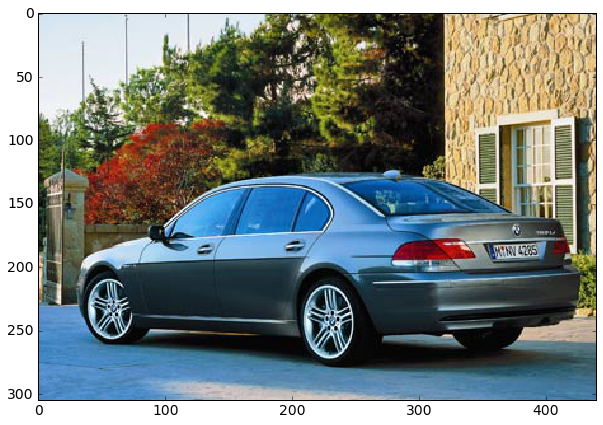

In [4]:
import json
import os.path as osp

valFile = open('data/3Dpascal/pascal3D/cache/val/val.txt', 'r')
basePath = 'data/3Dpascal/pascal3D/'

val = [line.rstrip('\n').split(' ') for line in valFile]
valPair = val[np.random.choice(len(val), 1)]

imfile = osp.join(basePath, valPair[0])
annfile = osp.join(basePath, valPair[1])

ann = json.load(open(annfile, 'r'))
gtpose = ann['annotation'][0]['aziLabel']
    

# set net to batch size of 1
image_resize = 300
net.blobs['data'].reshape(1,3,image_resize,image_resize)

image = caffe.io.load_image(imfile)
plt.imshow(image)

* Run the net and examine the top_k results

In [5]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
detections = net.forward()['detection_out']

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]
det_pose = detections[0, 0, :, 7]
det_poseScore = detections[0,0,:,8]

#print(det_pose)
#print(det_poseScore)

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.4]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(voc_labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]
top_pose = det_pose[top_indices]
top_poseScore = det_poseScore[top_indices]

In [12]:
print det_conf
print det_conf.shape
print det_ymax.shape
print det_pose.shape

[  1.63273897e-03   1.57532981e-03   1.00051891e-03   1.03569543e-02
   1.68071280e-03   1.16361736e-03   1.01342879e-03   9.31250979e-04
   9.99304175e-01   7.09553715e-03   5.58886863e-03   3.90348444e-03
   3.55886132e-03   3.44516919e-03   3.30059230e-03   2.97791883e-03
   2.85710441e-03   2.82195490e-03   2.74614710e-03   2.67597986e-03
   2.67249229e-03   2.62475712e-03   2.55553122e-03   2.53252895e-03
   2.47871620e-03   2.44210707e-03   2.27283360e-03   2.27041589e-03
   2.20480259e-03   2.18836055e-03   2.18163617e-03   2.09774519e-03
   2.02388898e-03   1.99432997e-03   1.90686516e-03   1.85737142e-03
   1.82358734e-03   1.59184262e-03   1.56850240e-03   1.54581631e-03
   1.51762075e-03   1.47809461e-03   1.47658132e-03   1.46658276e-03
   1.45788712e-03   1.42401457e-03   1.40170881e-03   1.38141261e-03
   1.38137885e-03   1.35672337e-03   1.33918331e-03   1.33737817e-03
   1.33075810e-03   1.32689928e-03   1.32584362e-03   1.31094700e-03
   1.28147763e-03   1.27967086e-03

* Plot the boxes

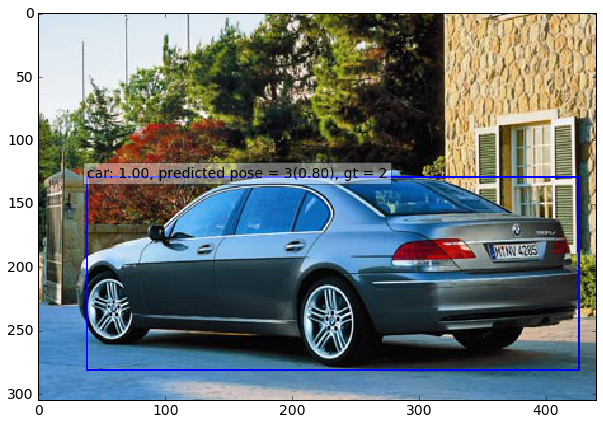

In [6]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.imshow(image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = top_labels[i]
    pose = top_pose[i]
    pose_score = top_poseScore[i]
    name = '%s: %.2f, predicted pose = %d(%.2f), gt = %d'%(label, score, int(pose), pose_score, gtpose)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[i % len(colors)]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.4})